**Things to Implement:**
1. ~~weight initialization methods~~
2. Validation set for hyperparameter tuning
    + Hyperparameters:
        + depth
        + width
        + learning rate $\eta$
        + batch size $B$
        + convergence criteria
3. Making sure input data is zero-centered with normalized variance
     + Maybe normalize the response variable as well
4. Momentum in stochastic gradient descent
5. Annealing (decaying) learning rate
    + multiply by a constant on every iteration
    + or reduce it when the validation loss isn't decreasing any more.
6. Stopping Criterion
    + based on average batch loss?
7. Weight regularization
    + to control overfitting

### Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### Generating Toy Data

In [2]:
x1 = np.random.normal(loc=5, scale=2, size=40) # generate 40 values from Normal(5, 2)
x2 = np.random.normal(loc=10, scale=2, size=40) # generate 40 values from Normal(10, 2)

# define coeffients to use for linear combination
beta_0 = 3
beta_1 = 0.5
beta_2 = 0.75

# Define X and y
X = np.concatenate([x1.reshape(40, 1), x2.reshape(40, 1)], axis=1)
y = beta_0 + (beta_1 * X[:, 0]) + (beta_2 * X[:, 1])

X_batch = X
X_batch.shape

(40, 2)

(0, 20)

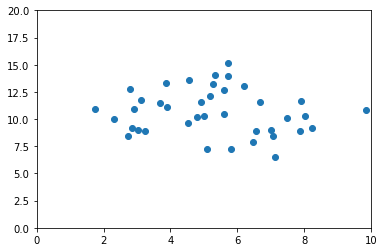

In [3]:
plt.scatter(X[:, 0], X[:, 1], cmap=y)
plt.xlim(0, 10)
plt.ylim(0, 20)

### Functions

In [6]:
def ReLU(vec):
    return np.where(vec <= 0, 0, vec)


def ReLU_derivative(vec):
    return np.where(vec <= 0, 0, 1)


def leaky_ReLU(vec):
    return np.where(vec <= 0, 0.1 * vec, vec)


def loss(num, y):
    return (1/2) * ((num - y) ** 2)


def average_batch_loss(vec, y):
    B = vec.shape[0]
    losses = loss(vec, y)
    return (1 / B) * losses.sum()


def get_batch(X, y, batch_size):
    indices = np.random.randint(X.shape[0], size=batch_size)
    return X[indices, :], y[indices]

### Defining Layers

**Types of Layers:**
1. Loss layer (final layer)
2. Output layer (single scalar value z)
3. Activation layer (activation function sigma applied to hidden layer)
4. Hidden layer

In [8]:
class LossLayer:
    def __init__(self, avg_loss=None, y_vec=None):
        self.avg_loss = None
        self.y_vec = y_vec
        
    def __repr__(self):
        return '{layer type: Loss, average loss: ' +  (str(self.avg_loss) if self.avg_loss is not None else "None") +  ', true y values shape: ' + (str(self.y_vec.shape) if self.y_vec is not None else "None") + '}'
    
    def __str__(self):
        return repr(self)
    
    
class OutputLayer:
    def __init__(self, array=None, weights=None):
        self.array = array
        self.weights = weights
        
    def __repr__(self):
        return '{layer type: Output, output array shape: ' +  (str(self.array.shape) if self.array is not None else "None") + ', weights shape: ' + (str(self.weights.shape) if self.weights is not None else "None") + '}'
    
    def __str__(self):
        return repr(self)
    

class ActivationLayer:
    def __init__(self, array=None):
        self.array = array
        
    def __repr__(self):
        return '{layer type: Activation, output array shape: ' + (str(self.array.shape) if self.array is not None else "None") + '}'
    def __str__(self):
        return repr(self)
    
    
class HiddenLayer:
    def __init__(self, array=None, weights=None):
        self.array = array
        self.weights = weights
        
    def __repr__(self):
        return '{layer type: Hidden, output array shape: ' + (str(self.array.shape) if self.array is not None else "None") + ', weights shape: ' + (str(self.weights.shape) if self.weights is not None else "None") + '}'

### Implementing Network

In [9]:
class NeuralNetwork:
    def __init__(self, depth, width, input_shape):
        self.depth = depth
        self.width = width
        self.B = input_shape[0]
        self.M = input_shape[1]  # This is number of features in the input batch
        self.layers = []
        self.num_hyperparameters = 0
        self.losses = []

        # Initializing the layers in the network

        for i in range(self.depth):
            # make the hidden layer first
            if i == 0:  # if this is the first hidden layer
                # then the number of rows in weight has to match number of columns
                h_layer = HiddenLayer(weights=self.__initialize_weights(shape=(self.M + 1, self.width), method="He"))
                self.num_hyperparameters += (self.M + 1) * self.width
            else:  # if this is not the first hidden layer
                # then weights should be of dimension (width x width)
                h_layer = HiddenLayer(weights = self.__initialize_weights(shape=(self.width + 1, self.width), method="He"))
                self.num_hyperparameters += (self.width + 1) * self.width

            # then make the activation layer for that hidden layer
            sigma_layer = ActivationLayer()

            self.layers.append(h_layer)
            self.layers.append(sigma_layer)

        # make an output layer that creates a scalar with its weights
        z_layer = OutputLayer(weights=self.__initialize_weights(shape=(self.width + 1, 1), method="He"))
        self.num_hyperparameters += (self.width + 1) * 1
        self.layers.append(z_layer)

        # make a loss layer
        loss_layer = LossLayer()
        self.layers.append(loss_layer)

    def __repr__(self):
        return '[' + '\n'.join([str(layer) for layer in self.layers]) + ']'

    def __str__(self):
        return repr(self)

    def get_avg_batch_loss(self):
        return self.layers[-1].avg_loss
    
    def __initialize_weights(self, shape, method = "Common"):
        if method == "Common":
            return np.random.uniform((-1 / np.sqrt(self.B)), (1 / np.sqrt(self.B)), size=shape)
        elif method == "He":
            return np.random.normal(loc=0, scale=np.sqrt(2 / self.B), size=shape)
            
        

    def forward_pass(self, X_batch, y_vec):

        # Append column of 1s to end of this batch, to hide bias term
        X_w_bias = np.concatenate([X_batch, np.ones(shape=(self.B, 1))], axis=1)
        i = 0

        # first apply weights to input layer and save result in first hidden layer
        self.layers[0].array = X_w_bias.dot(self.layers[0].weights)

        i += 1

        while i < len(self.layers):
            if isinstance(self.layers[i], LossLayer):  # if this is a LossLayer:
                # then apply loss function to B x 1 vector to get 1 x 1 average loss over this batch
                avg_loss = average_batch_loss(self.layers[i - 1].array, y_vec)
                self.layers[i].avg_loss = avg_loss
                self.losses.append(avg_loss)
                self.layers[i].y_vec = y_vec
            elif isinstance(self.layers[i], ActivationLayer):  # if this is an activation layer
                # then apply activation function to previous layer and save result
                self.layers[i].array = ReLU(self.layers[i - 1].array)
            else:  # if this is a Hidden Layer of an Output Layer:
                # add bias column, then apply this layer's weights to the previous layer and save result in current layer
                input_w_bias = np.concatenate([self.layers[i - 1].array, np.ones(shape=(self.B, 1))], axis=1)
                self.layers[i].array = input_w_bias.dot(self.layers[i].weights)


            i += 1

    def backward_pass(self, X_batch, learning_rate):
        X_w_bias = np.concatenate([X_batch, np.ones(shape=(self.B, 1))], axis=1)

        i = len(self.layers) - 1  # start at the loss layer

        while i > 0:  # while we still have layers to traverse through backwards that aren't the first hidden layer
            if isinstance(self.layers[i], LossLayer):  # if this is a loss layer:
                input_x_vec = self.layers[i - 1].array  # get the x values that were inputted to this loss function
                J = input_x_vec - self.layers[i].y_vec.reshape(self.B, 1)  # the derivative of our loss function is just x - y
            elif isinstance(self.layers[i], ActivationLayer):  # if this is an activation layer:
                J_update = ReLU_derivative(self.layers[i - 1].array)  # calcluate derivative (of ReLU) of every value that was inputted to this layer
                J = J * J_update  # update J with these values
            else:  # if this is a hidden layer or output layer (anything that has weights)
                # append bias vector to the array that was inputted to this layer:
                input_w_bias = np.concatenate([self.layers[i - 1].array, np.ones(shape=(self.B, 1))], axis=1)

                weight_update = np.transpose(input_w_bias).dot(J)  # calculate the weight update by doing xT * J
                J = J.dot(np.transpose(self.layers[i].weights[:-1, :]))  # Update the Jacobian by doing J * wT

                self.layers[i].weights = self.layers[i].weights - (learning_rate * weight_update)  # apply the weight update, multiplying by learning rate first
            i -= 1

        # now we update the weights of the very first hidden layer (it has special weight dimensions)
        # so i = 0

        weight_update = np.transpose(X_w_bias).dot(J)  # result is 3 x 3

        self.layers[i].weights = self.layers[i].weights - (
                    learning_rate * weight_update)  # apply the weight update, multiplying by learning rate first
        
    def backward_pass_momentum(self, X_batch, learning_rate, momentum):
        pass
    
    def train(self, X, y, batch_size, learning_rate, num_iterations):
        print("Number of trainable parameters: {}".format(self.num_hyperparameters))
        
        for i in range(num_iterations):
            this_X, this_y = get_batch(X, y, batch_size)
            self.forward_pass(this_X, this_y)
            self.backward_pass(this_X, learning_rate)

        print("Average batch loss: {}".format(self.get_avg_batch_loss()))
        
        plt.plot(range(num_iterations), self.losses)
        plt.show()
        
        

In [11]:
X_batch.shape

(40, 2)

In [12]:
net = NeuralNetwork(depth=2, width=4, input_shape=(40, 2))
net.forward_pass(X_batch, y)
net.layers

[{layer type: Hidden, output array shape: (40, 4), weights shape: (3, 4)},
 {layer type: Activation, output array shape: (40, 4)},
 {layer type: Hidden, output array shape: (40, 4), weights shape: (5, 4)},
 {layer type: Activation, output array shape: (40, 4)},
 {layer type: Output, output array shape: (40, 1), weights shape: (5, 1)},
 {layer type: Loss, average loss: 3267.001861822582, true y values shape: (40,)}]

In [13]:
net.backward_pass(X_batch, 0.001)

### Trying the Training Process

#### Creating 2000 rows of data

In [10]:
# number of rows to create
nrows = 2000

# define x features
x1 = np.random.normal(loc=5, scale=2, size=nrows) # generate 40 values from Normal(5, 2)
x2 = np.random.normal(loc=10, scale=2, size=nrows) # generate 40 values from Normal(10, 2)

# define coeffients to use for linear combination
beta_0 = 3
beta_1 = 0.5
beta_2 = 0.75

# Define X and y
X = np.concatenate([x1.reshape(nrows, 1), x2.reshape(nrows, 1)], axis=1)
y = beta_0 + (beta_1 * X[:, 0]) + (beta_2 * X[:, 1])  # make a linear combination of x1 and x2 to be y

#### Training

Number of trainable parameters: 37
Average batch loss: 447.87818645694495


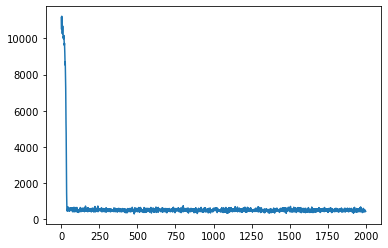

In [16]:
# Hyperparameters:
batch_size = 128
learning_rate = 0.00001
max_num_iterations = 2000
width = 4
depth = 2

# Training:
train_net = NeuralNetwork(depth, width, input_shape=(batch_size, X.shape[1]))
train_net.train(X, y, batch_size, learning_rate, max_num_iterations)

Number of trainable parameters: 23151
Average batch loss: 22684.78741902054


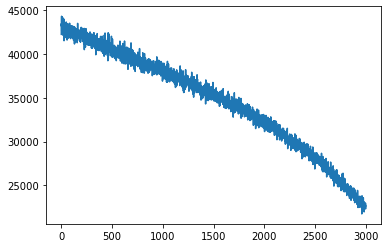

In [17]:
# Hyperparameters:
batch_size = 500
learning_rate = 0.0000001
max_num_iterations = 3000
width = 50
depth = 10

# Training:
train_net = NeuralNetwork(depth, width, input_shape=(batch_size, X.shape[1]))
train_net.train(X, y, batch_size, learning_rate, max_num_iterations)